**Image data mounting**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load dataset**

In [2]:
from scipy import io
import os
import numpy as np
import matplotlib.pyplot as plt

matlist = os.listdir('/content/drive/My Drive/11')
matlist.sort()
print(matlist)

<ipython-input-2-95c921676ba5>:1: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  from scipy import io


['0000002.mat', '0000003.mat', '0000004.mat', '0000005.mat', '0000006.mat', '0000007.mat', '0000008.mat', '0000009.mat', '0000010.mat', '0000011.mat', '0000012.mat', '0000013.mat', '0000014.mat', '0000015.mat', '0000016.mat', '0000018.mat', '0000019.mat', '0000020.mat', '0000021.mat', '0000022.mat', '0000023.mat', '0000024.mat', '0000027.mat', '0000028.mat', '0000029.mat', '0000030.mat', '0000031.mat', '0000032.mat', '0000033.mat', '0000034.mat', '0000035.mat', '0000036.mat', '0000037.mat', '0000038.mat', '0000039.mat', '0000040.mat', '0000041.mat', '0000042.mat', '0000043.mat', '0000044.mat', '0000046.mat', '0000048.mat', '0000049.mat', '0000050.mat', '0000051.mat', '0000053.mat', '0000054.mat', '0000055.mat', '0000056.mat', '0000057.mat', '0000059.mat', '0000060.mat', '0000061.mat', '0000062.mat', '0000063.mat', '0000064.mat', '0000065.mat', '0000066.mat', '0000068.mat', '0000069.mat', '0000075.mat', '0000077.mat', '0000080.mat', '0000081.mat', '0000085.mat', '0000088.mat', '0000091.

In [3]:
!pip install numpy==1.21.6

**Preview dataset**

In [4]:
data_set = []
label_set = []
num = 0

for i in matlist[0:]:
  mat_file = io.loadmat('/content/drive/My Drive/11/'+i)
  numbers = mat_file['Y']
  info = mat_file['diaginfo']
  label = info['kneejointid'][0][0][0] - 2

  x1 = 510
  x2 = 638

  # 1차 배치
  for j in range(100,150):
    if numbers[x1,j,0] == 0: break
  if j == 149:
    x1 = x1 + 70
    x2 = x2 + 70

  # 2차 배치
  max_col = np.argmax(numbers[x1:x2,0:,0], axis = 1)
  max = []
  k = x1

  for j in max_col:
    max.append(numbers[k,j,0])
    k += 1

  # 출력
  x1 = np.argmax(max) + x1 - 64
  x2 = np.argmax(max) + x2 - 64

  data_set.append(numbers[x1:x2,0:128,0])
  data_set.append(numbers[x1:x2,128:,0])
  label_set.append(label[0])
  label_set.append(label[1])

data_set = np.array(data_set, dtype = 'long')
data_set = data_set[np.newaxis,:,:,:]
label_set = np.array(label_set, dtype = 'long')

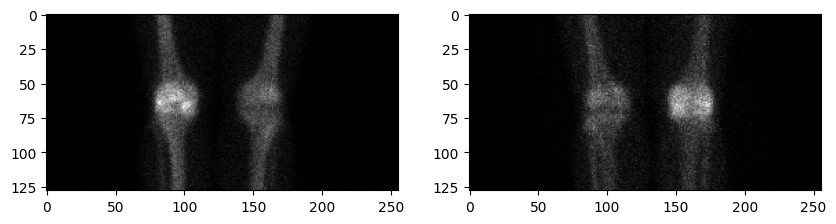

<Figure size 1000x300 with 0 Axes>

In [6]:
# 이미지 확인
f, (ax1, ax2) = plt.subplots(1,2)
plt.figure(figsize=(10,3))
f.set_size_inches(10,10)
ax1.imshow(numbers[x1:x2,0:,0],cmap='gray')
ax2.imshow(numbers[x1:x2,0:,1],cmap='gray')

# data_set 구성
# data_set = data_set.append((torch.tensor(numbers[x1:x2,0:128,0]),label[0]))

In [7]:
import torch

data_set_t=[]

for i in range(0,402):
  data_set_t.append((data_set[:,i,:,:], label_set[i]))

print(type(data_set))
print(data_set_t[0])
print(len(data_set_t))
print(label_set.shape)
print(label_set.dtype)


<class 'numpy.ndarray'>
(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 1]]]), 0)
402
(402,)
int64


**Data selection for test**

In [8]:
from random import randrange

test_data_set = []
test_label_set = []

for i in range(160,200):
  test_data_set.append(data_set_t[i])
  test_label_set.append(label_set[i])

test_data_set = np.array(test_data_set)
test_label_set = np.array(test_label_set)

test_label_set.dtype

<ipython-input-8-49a798926b01>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data_set = np.array(test_data_set)


dtype('int64')

**Import torch**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import time

**Setup device**

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cpu


**Progress** **monitor**

In [11]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):

    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)

    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))

    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

**CNN model**

In [12]:
class SimpleCNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d( in_channels=1, out_channels=16, kernel_size=3, padding=1 ),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d( in_channels=16, out_channels=32, kernel_size=3, padding=1 ),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d( in_channels=32, out_channels=64, kernel_size=3, padding=1 ),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(16*16*64,5),
        nn.ReLU(),
    )

  def forward(self, x):
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)

    x = x.view( x.size(0), -1 ) # flatten
    x = self.fc_layers(x)
    return x

**Hyperparameter**

In [21]:
learning_rate = 0.001
batch_size = 32
num_epochs = 100

**Model 초기화**

In [22]:
model = SimpleCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(data_set_t, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data_set, batch_size=batch_size, shuffle=True)

# dataiter = iter(train_dataloader)
# images, labels = dataiter.next()

**Training**

In [ ]:
model.train()
start_time = time.time()
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    running_loss = 0
    running_corrects = 0

    # 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력 후 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 기울기 계산 및 학습
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_set_t)
    epoch_acc = running_corrects / len(data_set_t) * 100
    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc)

    # 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() - start_time))

#    if epoch != 0:
#      if loss_list[epoch]==loss_list[epoch-1] and acc_list[epoch]==acc_list[epoch-1]: break

#1 Loss: 1.6232 Acc: 24.3781% Time: 7.9041s
#2 Loss: 1.6052 Acc: 24.1294% Time: 15.1467s
#3 Loss: 1.6055 Acc: 24.3781% Time: 23.3262s
#4 Loss: 1.6025 Acc: 23.6318% Time: 31.1486s
#5 Loss: 1.5871 Acc: 24.1294% Time: 39.3618s
#6 Loss: 1.5791 Acc: 23.8806% Time: 46.5636s
#7 Loss: 1.5829 Acc: 24.3781% Time: 54.6403s
#8 Loss: 1.5281 Acc: 23.6318% Time: 61.5270s
#9 Loss: 1.5325 Acc: 23.6318% Time: 69.6254s
#10 Loss: 1.5029 Acc: 23.8806% Time: 77.4449s
#11 Loss: 1.4955 Acc: 24.3781% Time: 85.4227s
#12 Loss: 1.4523 Acc: 24.1294% Time: 93.4820s
#13 Loss: 1.4382 Acc: 24.6269% Time: 100.6601s
#14 Loss: 1.4921 Acc: 24.3781% Time: 108.6986s
#15 Loss: 1.4905 Acc: 25.1244% Time: 115.4382s
#16 Loss: 1.4367 Acc: 24.6269% Time: 123.4949s
#17 Loss: 1.4768 Acc: 24.8756% Time: 130.5545s
#18 Loss: 1.3916 Acc: 24.8756% Time: 138.7514s
#19 Loss: 1.4004 Acc: 25.3731% Time: 146.2243s
#20 Loss: 1.3791 Acc: 25.1244% Time: 154.2234s
#21 Loss: 1.3418 Acc: 25.6219% Time: 161.4083s
#22 Loss: 1.3328 Acc: 25.6219% Time

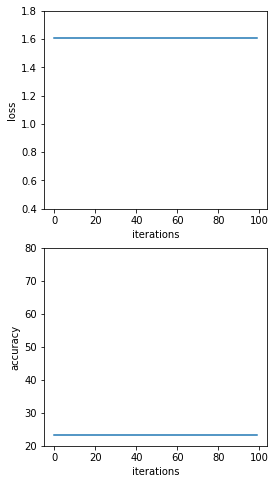

In [ ]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

x = np.arange(num_epochs)
ax1.plot(x, loss_list)
ax1.set_ylim([0.4,1.8])
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax2.plot(x, acc_list)
ax2.set_ylim([20,80])
ax2.set_xlabel('iterations')
ax2.set_ylabel('accuracy')
plt.show()